In [26]:
import ciao_contrib.runtool as rt
import sherpa.astro.ui as ui
import numpy as np
import matplotlib.pyplot as plt
import os
import re

#astropy is used to read WCS position information from fits files for region_count
from astropy.io import fits
from astropy import wcs
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance

#spreadsheet is used to store the list of obsids by epoch and read the obs header information for lightcurve_counts
import spreadsheet

#%matplotlib widget


def region_count(epoch_in):
    '''
    write _summary.txt files with the count rate and upper and lower bounds on the 90% confidence interval
    '''
    srcflx = rt.srcflux
    srcflx.punlearn() #Restore the system defaults for a CIAO parameter file.
    srcflx.infile = f'data/merge_test/epoch_{epoch_in}/merged_evt.fits'
    #with fits.open(srcflx.infile) as f:
        #loc = SkyCoord(f[1].header['RA_NOM']*u.deg,f[1].header['DEC_NOM']*u.deg)
        #loc_str = loc.ra.to_string(unit=u.hourangle, sep=':', pad=True, precision=2) + " " + loc.dec.to_string(unit=u.degree, sep=':', pad=True, precision=2)
    #srcflx.pos = loc_str #Reads RA, DEC columns as a position in sexagesimal "degree:arcmin:arcsec" format
    srcflx.pos = '13:09:48.0597,-23:22:52.836'
    srcflx.outroot = f'data/merge_test/epoch_{epoch_in}/srcflux_products/'
    srcflx.srcreg = f'regions/srcwcs.reg' #region used to calculate the source counts
    srcflx.bkgreg = f'regions/bkgwcs.reg'#region used to calculate the background counts
    srcflx.clobber = 'yes'
    srcflx.verbose = 0 #Default =1, 0 suppresses the long print statement
    srcflx() ## produces "_summary.txt" file with the output data parsed by read_counts

def merged_region_count(obsid_row,epoch_in):
    '''
    write _summary.txt files for merged observations
    '''
    srcflx = rt.srcflux
    srcflx.punlearn() #Restore the system defaults for a CIAO parameter file.
    srcflx.infile = str()
    for obsid in obsid_row:
        if srcflx.infile is None:
            srcflx.infile = f'data/{obsid}/repro/acisf{obsid}_repro_evt2.fits'
        else:
            srcflx.infile += f',data/{obsid}/repro/acisf{obsid}_repro_evt2.fits' ## includes leading comma
    print(srcflx.infile)
    srcflx.pos = '13:09:48.0597,-23:22:52.836'
    srcflx.outroot = f'data/epoch_{epoch_in}_srcflux_products/'
    srcflx.srcreg = f'regions/srcwcs.reg' #region used to calculate the source counts
    srcflx.bkgreg = f'regions/bkgwcs.reg'#region used to calculate the background counts
    srcflx.clobber = 'yes'
    srcflx.verbose = 0 #Default =1, 0 suppresses the long print statement
    srcflx() ## produces "_summary.txt" file with the output data parsed by read_counts
    
def read_counts(epoch):
    #filename = f'data/merge_test/epoch_{epoch}/srcflux_products/_summary.txt'
    filename = f'data/epoch_{epoch}_srcflux_products/_summary.txt'
    if not os.path.isfile(filename):
        obsid_row = spreadsheet.epoch_obsid_list[epoch] ## epoch needs to index from 0
        merged_region_count(obsid_row, epoch)
    with open(filename, encoding='utf-8') as f:
        for line in f:
            count_rate_match = re.search(r'[\d\.E\-]*\s(c/s)',line)
            lb_match = re.search(r'\([\d\.E\-]*\,', line)
            ub_match = re.search(r'\,[\d\.E\-]*\)', line)
            #0001|13 9 48.47 -23 22 58.4  Rate           0.0014 c/s (0.00104,0.00183)      
            if count_rate_match:
                cr = float(count_rate_match.group(0)[0:-4])
                lb = float(lb_match.group(0)[1:-1])
                ub = float(ub_match.group(0)[1:-1])
                return(cr, lb, ub)


def merge_obsids_into_epoch(obsid_in_list):
    '''
    params
    ------
    obsid_in_list : list
        List of observation IDs to be merged

    returns
    -------
    None
    '''
    ## previously used flxobs()
    mrgobs = rt.merge_obs
    epoch=4
    for obsid_row in obsid_in_list:
        mrgobs.punlearn()
        mrgobs.infiles = str()
        for obsid in obsid_row:
            if mrgobs.infiles is None:
                mrgobs.infiles = f'data/{obsid}/repro/acisf{obsid}_repro_evt2.fits'
            else:
                mrgobs.infiles += f', data/{obsid}/repro/acisf{obsid}_repro_evt2.fits' ## includes leading comma
        print('\nEpoch: '+str(epoch))
        print(mrgobs.infiles)

        mrgobs.outroot = f'data/merge_test/epoch_{epoch}/'
        mrgobs.clobber='yes'
        mrgobs()
        epoch +=1

def lightcurve_counts(epoch_in_list):
    '''
    produce a light curve of count rate vs time
    '''
    counts_list = []
    t_list = epoch_in_list
    yerr_list = []
    xerr_list = []
    for epoch in epoch_in_list:
        [count, lb, ub] = read_counts(epoch)
        counts_list.append(count*10000)
        yerr_list.append(ub-lb)
        #[t_t0,exp_time]=spreadsheet.epoch_header_parse(epoch)
        #t_list.append(t_t0)
        #xerr_list.append(exp_time/(3600*24)) ## convert observation times to days
    
    fig = plt.figure()
    plt.errorbar(t_list, counts_list, fmt='bo', yerr=yerr_list)    
    #log scale on y axis
    plt.yscale('log')
    return()

def lightcurve_flux(epoch_in_list):
    '''
    produce a light curve of flux vs time
    '''
    flux_list = []
    yerr_list = []
    t_list = []
    xerr_list = []
    conf_int = '90'
    for epoch in epoch_in_list:
        [flux, lb, ub] = read_flux(epoch, conf_int)
        flux_list.append(flux)
        yerr_list.append((ub-lb)/2)
        [t,exp_time] = spreadsheet.epoch_header_parse(epoch)
        t_list.append(t)
        xerr_list.append(exp_time/(24*3600))
    
    fig = plt.figure()
    plt.errorbar(t_list, flux_list, fmt='bo', yerr=yerr_list, xerr=xerr_list)
    plt.yscale('log')
    plt.ylabel('Flux erg/cm2/s for 0.3-10 keV')
    plt.xlabel('Days since GW170817')
    plt.title(f'Flux vs T-$T_0$ for the {conf_int}% Confidence Interval')


def read_flux(epoch, confidence_interval):
    #filename = f'data/merge_test/epoch_{epoch}/srcflux_products/_summary.txt'
    filename = f'flux_products_{confidence_interval}/epoch_{epoch}_flux_summary.txt'
    with open(filename, encoding='utf-8') as f:
        for line in f:
            count_rate_match = re.search(r'(Unabs).*?([\d\.E\-]*)\s(erg/cm2/s)',line)
            lb_match = re.search(r'\([\d\.E\-]*\,', line)
            ub_match = re.search(r'\,[\d\.E\-]*\)', line)
            #0001|13 9 48.47 -23 22 58.4  Rate           0.0014 c/s (0.00104,0.00183)      
            if count_rate_match:
                #print('\n'+count_rate_match.group(0))
                #print(count_rate_match.group(2))
                cr = float(count_rate_match.group(2).lower())
                lb = float(lb_match.group(0)[1:-1].lower())
                ub = float(ub_match.group(0)[1:-1].lower())
                return(cr, lb, ub)

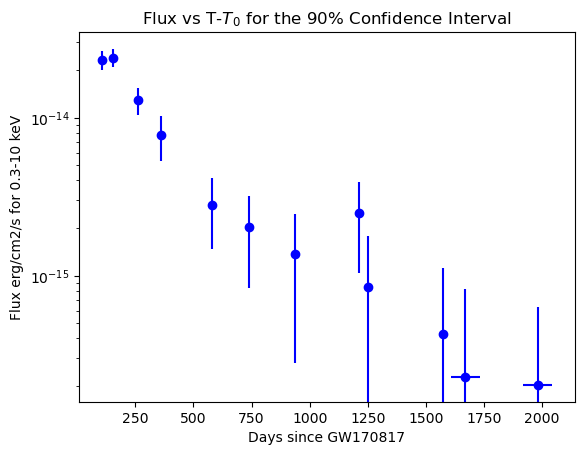

In [27]:
lightcurve_flux(range(12))

In [3]:
#reproject(20936, 20860)
#obsid = 20861
#[count, lb, ub] = region_count(obsid)
#print(f'Obs ID {obsid} observed a count rate of {count} c/s')

from spreadsheet import epoch_obsid_list as eol
merge_obsids_into_epoch(eol)

#merge_observations([20860, 20936])


Epoch: 4
data/20860/repro/acisf20860_repro_evt2.fits, data/20861/repro/acisf20861_repro_evt2.fits


KeyboardInterrupt: 

data/20860/repro/acisf20860_repro_evt2.fits,data/20861/repro/acisf20861_repro_evt2.fits
data/20936/repro/acisf20936_repro_evt2.fits,data/20937/repro/acisf20937_repro_evt2.fits,data/20938/repro/acisf20938_repro_evt2.fits,data/20939/repro/acisf20939_repro_evt2.fits,data/20945/repro/acisf20945_repro_evt2.fits
data/21080/repro/acisf21080_repro_evt2.fits,data/21090/repro/acisf21090_repro_evt2.fits
data/21371/repro/acisf21371_repro_evt2.fits
data/21322/repro/acisf21322_repro_evt2.fits,data/22157/repro/acisf22157_repro_evt2.fits,data/22158/repro/acisf22158_repro_evt2.fits
data/21372/repro/acisf21372_repro_evt2.fits,data/22736/repro/acisf22736_repro_evt2.fits,data/22737/repro/acisf22737_repro_evt2.fits
data/21323/repro/acisf21323_repro_evt2.fits,data/23183/repro/acisf23183_repro_evt2.fits,data/23184/repro/acisf23184_repro_evt2.fits,data/23185/repro/acisf23185_repro_evt2.fits
data/22677/repro/acisf22677_repro_evt2.fits,data/24887/repro/acisf24887_repro_evt2.fits,data/24888/repro/acisf24888_repr

()

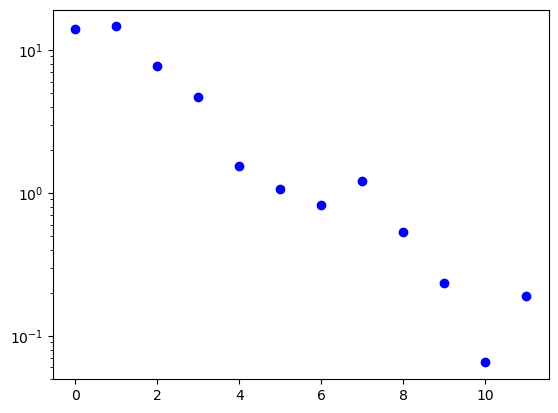

In [ ]:
from spreadsheet import epoch_obsid_list as eol
lightcurve_counts(range(len(eol)))
